*第一步，定义模型框架函数*

In [1]:
# 这个程序是针对已经训练好的模型进行特征提取，然后进行数据可视化、利用特征进行分类等，分类器采用传统的机器学习方法
# cnn autoncoder model
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D,Reshape,UpSampling1D
from keras.models import Model, Sequential
from keras import initializers
from keras.layers import BatchNormalization

#CNN autoencoder
def CNN_encoder(input,dims):
  ## encoding part
  initializer = tf.keras.initializers.HeNormal()
  # 四层卷积层，再加池化层压缩数据最后再flat展开，一维卷积
  # 参数分别为卷积核个数即输出维度，卷积核大小，激活函数,padding是当卷积核超出边界时的处理方式,same是补0,padding的其他参数还有valid，不补0
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(input)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Dropout(0.25)(layer)

  layer = Flatten()(layer)
  # 这一层的作用是将输入展平。不影响批量大小。encoded的shape是(?, 512)
  encoded = Dense(dims, activation="relu")(layer)
  return encoded

# 解码函数，通过卷积层+上采样层，还原数据
def CNN_decoder(encoded):
  ## decoding part
  initializer = tf.keras.initializers.HeNormal()
  layer = Dense(250* 512, activation="relu", use_bias=False)(encoded)
  layer = Reshape((250, 512))(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D()(layer)
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(layer)
  layer = BatchNormalization()(layer)
  layer = UpSampling1D()(layer)
  decoded = Conv1D(1, kernel_size=3, padding="same", activation="sigmoid")(layer)

  return decoded
def CAE_model(Train_X,dims):
  CNNinput_layer = Input(shape=(Train_X.shape[1],1))
  # 编码后的数据
  cnn_x = CNN_encoder(CNNinput_layer,dims)
  # 解码后的数据
  cnn_x_hat = CNN_decoder(cnn_x)
  # 把编码和解码拼接成一个模型
  CNNmodel = Model(CNNinput_layer, cnn_x_hat)
  CNN_enconder = Model(CNNinput_layer, cnn_x, name="encoder")
  return CNNmodel,CNN_enconder

def CAE_hiddenrepresentation(data,method_enconder):
        """Transform the vector.
        From original dimensions to latent dimensions.
        Parameters
        ----------
        data : array-like  (n_samples, n_features)
            The input data to use in transform process.
        Returns
        -------
        _ : array-like  (n_samples, value_encoding_dim)
            The data transformed to latent dimensions format.
        """
        return method_enconder.predict(data)
      
# 截取编码层
def CNNextractrep(model):
  hidden_representation = Sequential()
  for i in range(19):  # Adjust this number based on the total number of layers in your model
    hidden_representation.add(model.layers[i])
  return hidden_representation

def CNNextractdec(model):
  decode_representation = Sequential()
  total_layers = len(model.layers)
  for i in range(20,34):  # Start from 20th layer and go till the end
    decode_representation.add(model.layers[i])
  return decode_representation

In [2]:
%load_ext autotime
#限制显存
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

time: 48 ms (started: 2024-06-08 13:09:10 +08:00)


In [3]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing 
from sklearn import svm
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import History
from sklearn.metrics import confusion_matrix
import re
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import ClusterCentroids


sns.set(style="whitegrid")
np.random.seed(203)
# drive.mount('/content/drive')

# 将原始数据压缩到700维
encodding_dim=700
# 1k采样，4s


#读取数据
data=pd.read_csv('/home/Q/dataset/DAIC-WOZ/output_1k/470.csv')
#数据预处理
#---------before training perform Max-Min scalling
pre_data=data
# data = data.iloc[0:1,:]

CAE_model, _ = CAE_model(data, encodding_dim)

# 加载已训练模型的权重
CAE_model.load_weights("/home/Q/Diploma_thesis/CAE_ADD-main/models/modeltotalCAE_norm_1k.h5")

Scaler = MinMaxScaler()





2024-06-08 13:09:11.560025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 13:09:11.699306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9
2024-06-08 13:09:12.665348: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358400000 exceeds 10% of free system memory.
2024-06-08 13:09:12.996030: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358400000 exceeds 10% of free system memory.


time: 2.75 s (started: 2024-06-08 13:09:10 +08:00)


In [4]:
CAE_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704 

In [5]:
#加载编码器
LatentRepresenation=CNNextractrep(CAE_model)

time: 131 ms (started: 2024-06-08 13:09:13 +08:00)


In [6]:
LatentRepresenation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704     
                                                                 
 batch_normalization_1 (Batc  (None, 2000, 128)        5

In [7]:
decode = CNNextractdec(CAE_model)

time: 11.4 ms (started: 2024-06-08 13:11:41 +08:00)


In [8]:
model_img_file = '/home/Q/Diploma_thesis/CAE_ADD-main/CAE_encode_model.png' 
tf.keras.utils.plot_model(decode, to_file=model_img_file,  
                          show_shapes=True,  
                          show_layer_activations=True,  
                          show_dtype=True, 
                          show_layer_names=True)   

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

time: 669 ms (started: 2024-06-08 13:11:42 +08:00)


In [9]:
LatentRepresenation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704     
                                                                 
 batch_normalization_1 (Batc  (None, 2000, 128)        5

第二步，*读取并且处理测试数据*

In [10]:
new_Train_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Train_total_CAE_1k.csv')
new_Test_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Test_total_CAE_1k.csv')
new_Dev_total=pd.read_csv('/home/Q/Diploma_thesis/CAE_ADD-main/data/new_Dev_total_CAE_1k.csv')

# Combine the datasets
combined = pd.concat([new_Train_total, new_Test_total])

# Randomly sample 3000 rows from the combined dataset
sampled = combined.sample(3000, replace=False)

time: 10.9 s (started: 2024-06-08 13:11:47 +08:00)


In [11]:
#数据标准化
#---------before training perform Max-Min scalling
Scaler=preprocessing.MinMaxScaler()  # 实例化一个MinMaxScaler对象，用于最大最小值缩放
x_train = new_Train_total.drop(["Class"], axis=1)  # 从new_Train_total中删除"Class"列，得到训练数据
y_train = new_Train_total["Class"].values  # 获取训练数据的标签

x_scaled_train = Scaler.fit_transform(x_train.values)  # 使用MinMaxScaler对训练数据进行最大最小值缩放
# nondep和dep分别是非依赖和依赖的意思，nondep是标签为0的数据，dep是标签为1的数据
x_nondep_train, x_dep_train = x_scaled_train[y_train == 0], x_scaled_train[y_train == 1]  # 将缩放后的训练数据分为非依赖和依赖两部分
#---------before validating perform Max-Min scalling
x_val = new_Dev_total.drop(["Class"], axis=1)  # 从new_Dev_total中删除"Class"列，得到验证数据
y_val = new_Dev_total["Class"].values  # 获取验证数据的标签

x_scaled_val = Scaler.transform(x_val.values)  # 使用之前实例化的MinMaxScaler对验证数据进行最大最小值缩放
x_nondep_val, x_dep_val = x_scaled_val[y_val == 0], x_scaled_val[y_val == 1]  # 将缩放后的验证数据分为非依赖和依赖两部分
#---------before testing perform Max-Min scalling

x_test = new_Test_total.drop(["Class"], axis=1)  # 从new_Test_total中删除"Class"列，得到测试数据
y_test = new_Test_total["Class"].values  # 获取测试数据的标签

x_scaled_test = Scaler.transform(x_test.values)  # 使用之前实例化的MinMaxScaler对测试数据进行最大最小值缩放
x_nondep_test, x_dep_test = x_scaled_test[y_test== 0], x_scaled_test[y_test == 1]  # 将缩放后的测试数据分为非依赖和依赖两部分

x_sampled = sampled.drop(["Class"], axis=1)  # 从new_Test_total中删除"Class"列，得到测试数据
y_sampled = sampled["Class"].values  # 获取测试数据的标签

x_scaled_sampled = Scaler.transform(x_sampled.values)  # 使用之前实例化的MinMaxScaler对测试数据进行最大最小值缩放
x_nondep_sampled, x_dep_sampled = x_scaled_sampled[y_sampled== 0], x_scaled_sampled[y_sampled == 1]  # 将缩放后的测试数据分为非依赖和依赖两部分



time: 2.61 s (started: 2024-06-08 13:11:58 +08:00)


In [12]:
pd.DataFrame(x_scaled_test).head(5)

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.384796,0.439004,0.424407,0.541939,0.307490,0.302496,0.771353,0.517064,0.665956,0.787890,...,0.574394,0.717507,0.741915,0.715628,0.648267,0.369802,0.474514,0.334435,0.318865,0.358260
1,0.378136,0.431168,0.422288,0.560172,0.317237,0.296302,0.763932,0.506980,0.665142,0.800537,...,0.549140,0.699518,0.724190,0.699499,0.617894,0.353102,0.456358,0.315711,0.303926,0.343231
2,0.351761,0.471801,0.461786,0.614562,0.319166,0.256592,0.750476,0.489037,0.665487,0.805570,...,0.554538,0.702403,0.725434,0.697196,0.612146,0.348248,0.448544,0.311313,0.296113,0.334838
3,0.371463,0.433310,0.399682,0.545420,0.307863,0.292539,0.765093,0.512749,0.670272,0.778561,...,0.554033,0.706951,0.730538,0.699678,0.620584,0.353257,0.457746,0.315764,0.303455,0.343121
4,0.411758,0.435922,0.429955,0.541081,0.316120,0.300481,0.770818,0.519771,0.664419,0.793296,...,0.485455,0.664720,0.694337,0.672301,0.574042,0.333636,0.434276,0.280413,0.268059,0.359263


time: 25.3 ms (started: 2024-06-08 13:12:00 +08:00)


In [13]:
def encode(data):
  global Scaler
  global LatentRepresenation
  # audio全变成0了，我得看看是不是数据的问题
  # .values,将DataFrame对象转换为Numpy的ndarray对象。这是因为MinMaxScaler的transform方法需要一个ndarray对象
  data_scaled = Scaler.transform(data.values)
  print(pd.DataFrame(data_scaled).head(5))
  data_scaled = np.expand_dims(data_scaled, axis=2)
  encoded_features=LatentRepresenation.predict(data_scaled)
  return data_scaled,encoded_features

time: 738 µs (started: 2024-06-08 13:12:00 +08:00)


In [14]:
# 编码提取特征
LatentRepresenation=CNNextractrep(CAE_model)
print(LatentRepresenation.summary())

x_nondep_training_data=x_nondep_train.copy()
x_dep_training_data=x_dep_train.copy()

x_nondep_training_data = np.expand_dims(x_nondep_training_data, axis=2)
x_dep_training_data = np.expand_dims(x_dep_training_data, axis=2)

# 利用编码器进行特征提取——训练集
Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_training_data)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_training_data)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels

x_nondep_validation_data=x_nondep_val.copy()
x_dep_validation_data=x_dep_val.copy()

# 利用编码器进行特征提取——验证集
# validation是验证的意思
x_nondep_validation_data= np.expand_dims(x_nondep_validation_data, axis=2)
x_dep_validation_data = np.expand_dims(x_dep_validation_data, axis=2)

Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_validation_data)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_validation_data)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid .shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels


x_nondep_test_data=x_nondep_test.copy()
x_dep_test_data=x_dep_test.copy()

# 利用编码器进行特征提取——test集

x_nondep_test_data= np.expand_dims(x_nondep_test_data, axis=2)
x_dep_test_data = np.expand_dims(x_dep_test_data, axis=2)

Nondep_hid_rep_test =LatentRepresenation.predict(x_nondep_test_data)
Dep_hid_rep_test =LatentRepresenation.predict(x_dep_test_data)

rep_x_test = np.append(Nondep_hid_rep_test , Dep_hid_rep_test, axis = 0)#total latent representation
y_n_test = np.zeros(Nondep_hid_rep_test .shape[0])
y_d_test = np.ones(Dep_hid_rep_test.shape[0])
rep_y_test = np.append(y_n_test, y_d_test)#Total labels


# 利用编码器进行特征提取——sample集

x_nondep_sampled_data=x_nondep_sampled.copy()
x_dep_sampled_data=x_dep_sampled.copy()

x_nondep_sampled_data= np.expand_dims(x_nondep_sampled_data, axis=2)
x_dep_sampled_data = np.expand_dims(x_dep_sampled_data, axis=2)

Nondep_hid_rep_sampled =LatentRepresenation.predict(x_nondep_sampled_data)
Dep_hid_rep_sampled =LatentRepresenation.predict(x_dep_sampled_data)

rep_x_sampled = np.append(Nondep_hid_rep_sampled , Dep_hid_rep_sampled, axis = 0)#total latent representation
y_n_sampled = np.zeros(Nondep_hid_rep_sampled .shape[0])
y_d_sampled = np.ones(Dep_hid_rep_sampled.shape[0])
rep_y_sampled = np.append(y_n_sampled, y_d_sampled)#Total labels




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 4000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2000, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         24704     
                                                                 
 batch_normalization_1 (Batc  (None, 2000, 128)       

2024-06-08 13:12:01.803510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


 39/122 [========>.....................] - ETA: 0s

2024-06-08 13:12:02.025736: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - 0s 5ms/step
time: 4.71 s (started: 2024-06-08 13:12:00 +08:00)


In [18]:
# 读取中文原数据，并且编码
data_zh = pd.read_csv('/home/Q/dataset/audio_lanzhou_2015/data_resample/norm_2/1k/ZH_train.csv')
data_zh_label = data_zh.iloc[:,-1]
data_zh = data_zh.iloc[:,0:-1]

data_zh_scaled,data_zh_encoded = encode(data_zh)
# data_zh_scaled = Scaler.transform(data_zh.values)
# data_zh = np.expand_dims(data_zh_scaled, axis=2)
# data_zh_encoded = LatentRepresenation.predict(data_zh)


       0         1         2         3         4         5         6     \
0  0.336227  0.198774  0.407046  0.674017  0.296993  0.350629  0.756739   
1  0.397154  0.440299  0.424358  0.541365  0.309718  0.303618  0.772814   
2 -0.009119  0.372477  0.623202  0.558544  0.325924  0.300432  0.850346   
3  0.252094  0.210477  0.485228  0.735805  0.255012  0.305838  0.807613   
4  0.543759  0.476946  0.404767  0.445883  0.164559  0.360242  0.844894   

       7         8         9     ...      3990      3991      3992      3993  \
0  0.548209  0.720660  0.809376  ...  0.580038  0.764471  0.731084  0.715742   
1  0.522226  0.669639  0.792123  ...  0.546970  0.695367  0.720091  0.697032   
2  0.704031  0.613712  0.731005  ...  0.557195  0.739079  0.737357  0.710264   
3  0.589700  0.674973  0.733644  ...  0.575623  0.696736  0.756069  0.717341   
4  0.473414  0.662609  0.835582  ...  0.544679  0.697542  0.723843  0.699738   

       3994      3995      3996      3997      3998      3999  
0  0

In [19]:
# 读取中文原数据_all，并且编码
data_zh_2 = pd.read_csv('/home/Q/dataset/audio_lanzhou_2015/data_resample/norm_2/1k/ZH_test.csv')
data_zh_2_label = data_zh_2.iloc[:,-1]
data_zh_2 = data_zh_2.iloc[:,0:-1]

data_zh_2_scaled,data_zh_2_encoded = encode(data_zh_2)

       0         1         2         3         4         5         6     \
0  0.398300  0.442477  0.423876  0.537696  0.305375  0.298256  0.767636   
1  0.426752  0.472461  0.441958  0.544219  0.306097  0.294056  0.765756   
2  0.405903  0.411085  0.365463  0.475714  0.316199  0.302068  0.773049   
3  0.414094  0.464856  0.426560  0.536771  0.312846  0.300513  0.768767   
4  0.411318  0.478826  0.464062  0.565275  0.307590  0.285886  0.756899   

       7         8         9     ...      3990      3991      3992      3993  \
0  0.511036  0.662234  0.787476  ...  0.560737  0.706832  0.736413  0.715575   
1  0.510885  0.668009  0.796534  ...  0.561347  0.722703  0.730442  0.689941   
2  0.499395  0.662576  0.795115  ...  0.547878  0.696405  0.718944  0.693973   
3  0.515665  0.671001  0.792686  ...  0.564009  0.708816  0.730290  0.703739   
4  0.499627  0.655026  0.780960  ...  0.546482  0.696823  0.719664  0.693231   

       3994      3995      3996      3997      3998      3999  
0  0

In [14]:
# 直接读取中文CAE编码后的特征
zh_test = pd.read_csv('/home/Q/dataset/audio_lanzhou_2015/features/CAE/1k/zh_all.csv',header=None)
# CAE特征是在编码之前就归一化预处理过的
zh_test_val = zh_test.iloc[:, :-1].values
zh_test_label = zh_test.iloc[:, -1].values


FileNotFoundError: [Errno 2] No such file or directory: '/home/Q/dataset/audio_lanzhou_2015/features/CAE/1k/zh_all.csv'

time: 416 ms (started: 2024-05-02 10:27:08 +08:00)


In [20]:
# 计算MSE
import numpy as np
from sklearn.metrics import mean_squared_error

# 训练集和验证集的重构结果_en,train_reconstructed是训练集的重构结果，val_reconstructed是验证集的重构结果
train_reconstructed = CAE_model.predict(x_scaled_train)
val_reconstructed = CAE_model.predict(x_scaled_val)
test_reconstructed = CAE_model.predict(x_scaled_test)

# 计算训练集和验证集的MSE
train_mse = mean_squared_error(np.ravel(x_scaled_train), np.ravel(train_reconstructed))
val_mse = mean_squared_error(np.ravel(x_scaled_val), np.ravel(val_reconstructed))
test_mse = mean_squared_error(np.ravel(x_scaled_test), np.ravel(test_reconstructed))



# 不加BN层
# Training MSE: 0.02250038380645789
# Validation MSE: 0.02517618863782179

# zh
data_zh_reconstructed = CAE_model.predict(data_zh_scaled)

# 计算训练集和验证集的MSE
zh_mse = mean_squared_error(np.ravel(data_zh_scaled), np.ravel(data_zh_reconstructed))

print(f"Training MSE_en: {train_mse}")
print(f"Validation MSE_en: {val_mse}")
print(f"Test MSE_en: {test_mse}")
print(f"Testing MSE_zh: {zh_mse}")


183/183 [==============================] - 4s 17ms/step
Training MSE_en: 0.009621910440479912
Validation MSE_en: 0.012094306440684056
Test MSE_en: 0.0100081212325552
Testing MSE_zh: 0.00985494916584393
time: 14 s (started: 2024-06-08 13:17:03 +08:00)


In [25]:
def plot_dim_reduction(data_label_pairs, method='pca', merge=False,labels = ['valid_0', 'valid_1', 'zh_0', 'zh_1']):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import pandas as pd

    if method == 'pca':
        dim_reduction = PCA(n_components=2)
    elif method == 'tsne':
        dim_reduction = TSNE(n_components=2)
    else:
        raise ValueError("Invalid method. Expected 'pca' or 'tsne'")

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('2 component ' + method.upper(), fontsize = 20)
    colors = ['r', 'g', 'b', 'y']
    

    all_data = np.concatenate([data for data, _ in data_label_pairs])
    all_data_2d = dim_reduction.fit_transform(all_data)

    start = 0
    for i, (data, label) in enumerate(data_label_pairs):
        end = start + len(data)
        data_2d = all_data_2d[start:end]
        start = end

        df = pd.DataFrame(data = data_2d, columns = ['component 1', 'component 2'])
        df['label'] = label

        for target in [0, 1]:
            indicesToKeep = df['label'] == target
            ax.scatter(df.loc[indicesToKeep, 'component 1']
                       , df.loc[indicesToKeep, 'component 2']
                       , c = colors[i*2 + target]
                       , s = 10, label=labels[i*2 + target])
        if not merge:
            ax.legend()
            ax.grid()
            plt.show()
            fig = plt.figure(figsize = (8,8))
            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('Component 1', fontsize = 15)
            ax.set_ylabel('Component 2', fontsize = 15)
            ax.set_title('2 component ' + method.upper(), fontsize = 20)

    if merge:
        ax.legend()
        ax.grid()
        plt.show()

time: 4.8 ms (started: 2024-06-08 13:19:53 +08:00)


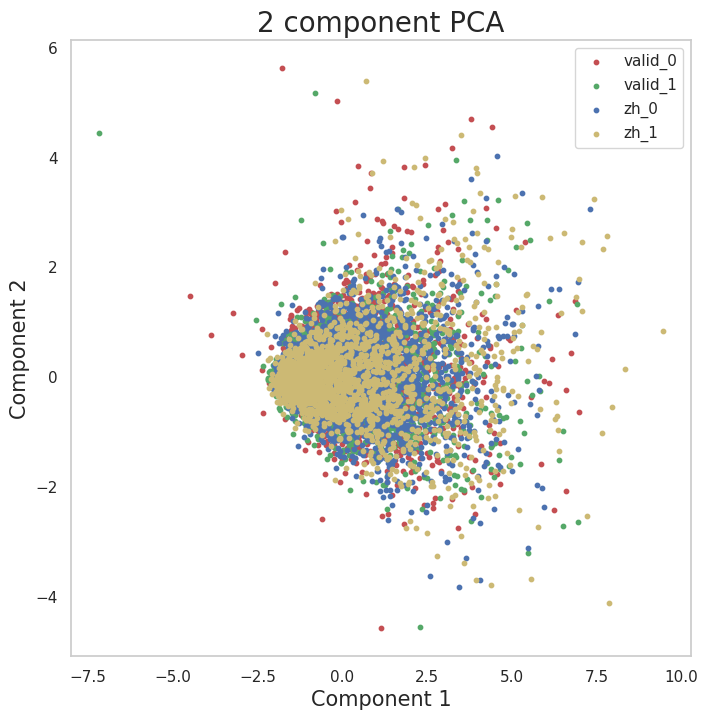

time: 661 ms (started: 2024-06-08 13:17:27 +08:00)


In [22]:
plot_dim_reduction([(rep_x_Train, rep_y_Train), (data_zh_encoded, data_zh_label)], method='pca',merge=True)

/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/Q/anaconda3/envs/CAE_ADD/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


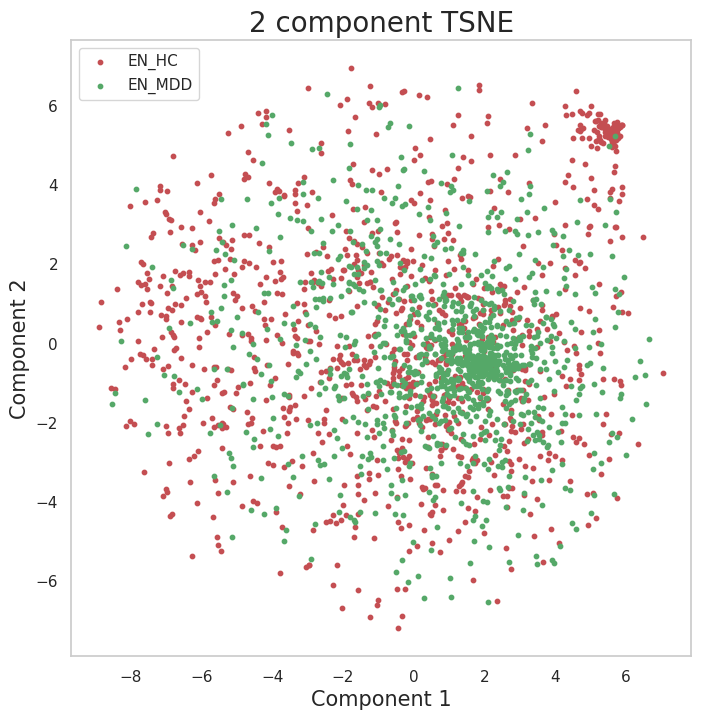

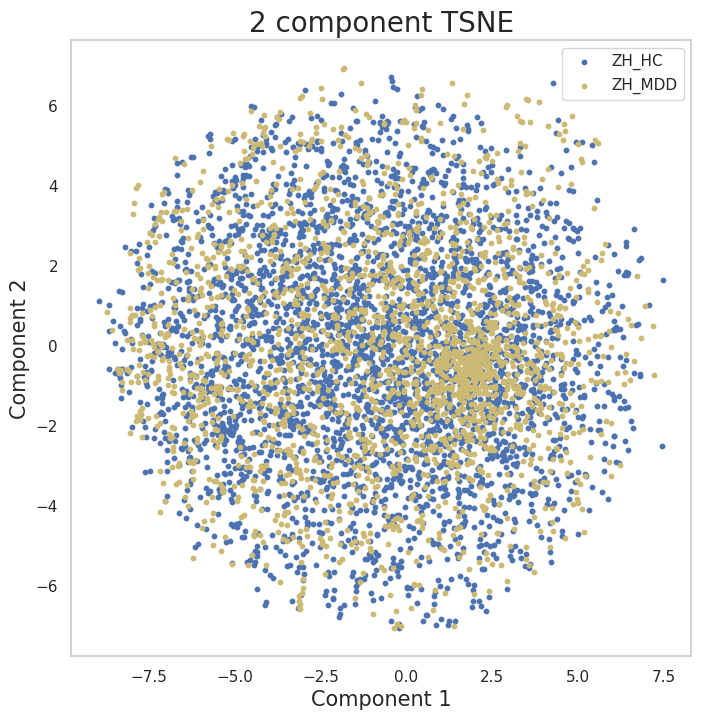

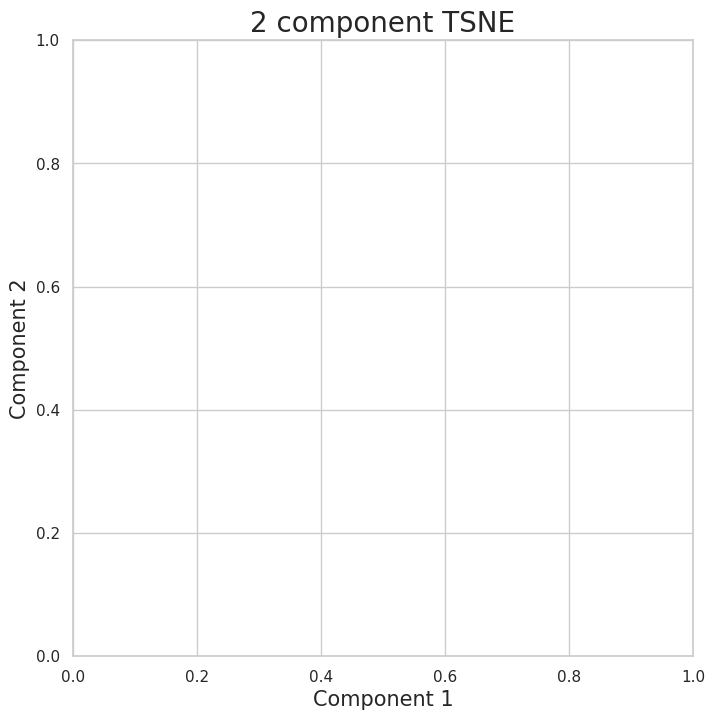

time: 30 s (started: 2024-06-08 13:21:15 +08:00)


In [28]:
label= ['EN_HC', 'EN_MDD', 'ZH_HC', 'ZH_MDD']
plot_dim_reduction([(rep_x_Valid, rep_y_Valid), (data_zh_encoded, data_zh_label)], method='tsne',merge=False,labels=label)

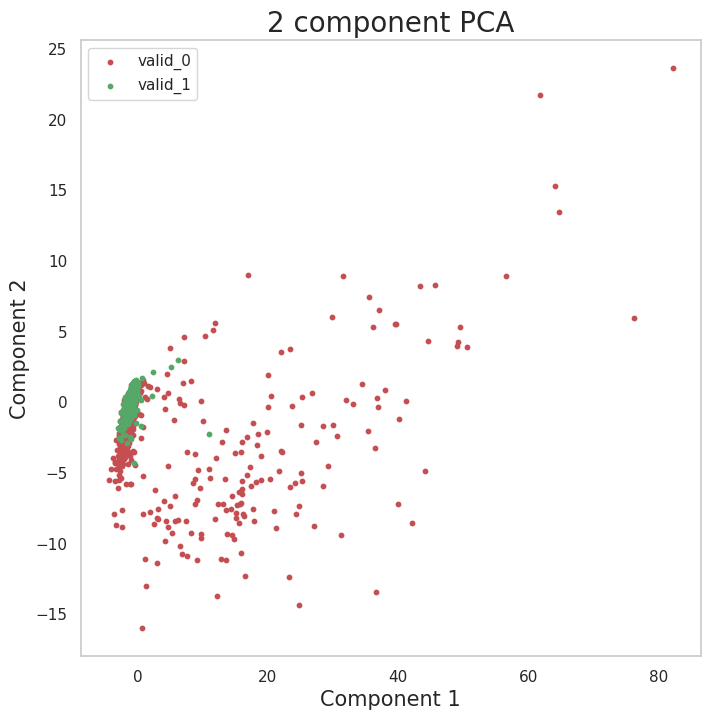

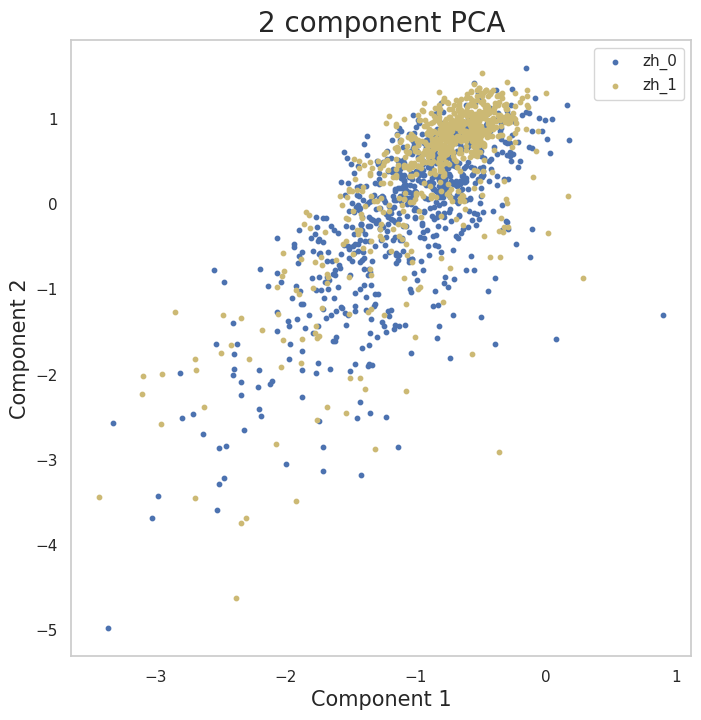

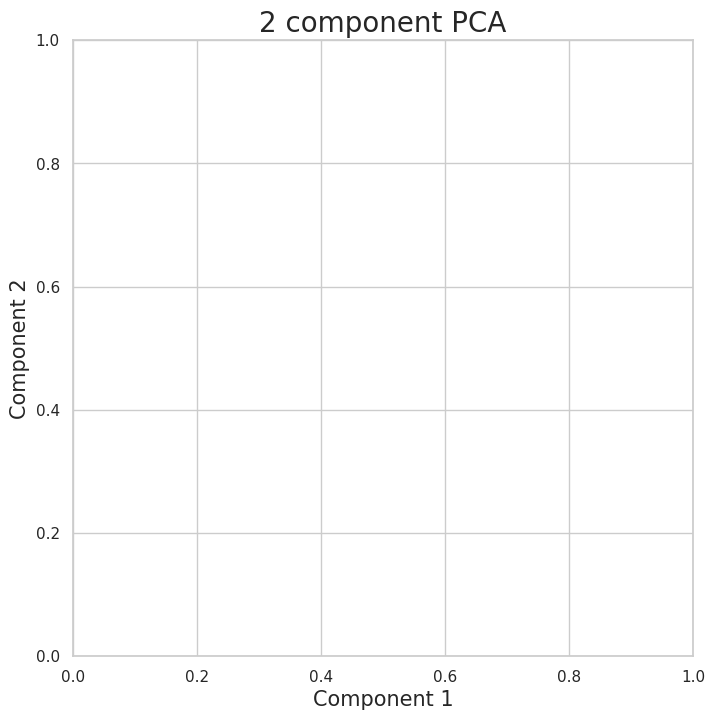

time: 3.7 s (started: 2024-05-06 06:35:51 +08:00)


In [23]:
plot_dim_reduction([(rep_x_Valid, rep_y_Valid), (data_zh_encoded, data_zh_label)], method='pca',merge=False)

*第三步，对提取完的特征使用传统机器学习方法进行训练*

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
%matplotlib inline


time: 33.4 ms (started: 2024-05-06 03:00:40 +08:00)


In [56]:
# 画图函数-混淆矩阵
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred).astype(int)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

time: 3.72 ms (started: 2024-05-06 03:00:44 +08:00)


In [35]:
# 支持向量机-训练
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=0.1, gamma=0.1)
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)

# Save the model
dump(clf, '/home/Q/Diploma_thesis/CAE_ADD-main/models/SVM_CAE_norm_1k.joblib') 

print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))


cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

print ("")
print(cm.diagonal())
print (confusion_matrix(rep_y_Valid, pred_y))


Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      1149
         1.0       0.77      0.75      0.76      1149

    accuracy                           0.77      2298
   macro avg       0.77      0.77      0.77      2298
weighted avg       0.77      0.77      0.77      2298


Accuracy Score:  0.7654482158398608

[0.78154917 0.74934726]
[[898 251]
 [288 861]]
time: 32.8 s (started: 2024-05-02 11:28:49 +08:00)


Normalized confusion matrix
[[0.87380331 0.12619669]
 [0.32114883 0.67885117]]


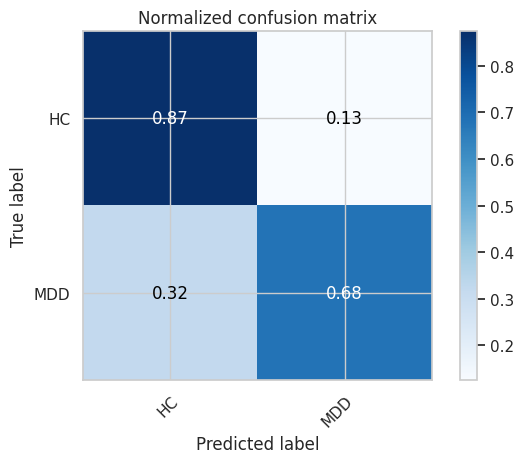

time: 236 ms (started: 2024-05-01 16:17:17 +08:00)


In [22]:
plot_confusion_matrix(rep_y_Valid, pred_y, classes=np.array(['HC', 'MDD']), normalize=True)
plt.show()

In [57]:
# 支持向量机-测试-en
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import load

# Load the model
clf = load('/home/Q/Diploma_thesis/CAE_ADD-main/models/SVM_CAE_norm_1k.joblib')

# Predict on zh_test_val
pred_y = clf.predict(rep_x_test)

# Print classification report
print("Classification Report: SVM on latent")
print(classification_report(rep_y_test, pred_y))

# Print accuracy score
print("Accuracy Score: ", accuracy_score(rep_y_test, pred_y))

# Compute and normalize confusion matrix
cm = confusion_matrix(rep_y_test, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print diagonal elements and the whole confusion matrix
print(cm.diagonal())
print(cm)
print(confusion_matrix(rep_y_test, pred_y))


Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.71      0.98      0.82      1527
         1.0       0.97      0.59      0.73      1527

    accuracy                           0.79      3054
   macro avg       0.84      0.79      0.78      3054
weighted avg       0.84      0.79      0.78      3054

Accuracy Score:  0.7871643745907008
[0.98428291 0.59004584]
[[0.98428291 0.01571709]
 [0.40995416 0.59004584]]
[[1503   24]
 [ 626  901]]
time: 37.4 s (started: 2024-05-06 03:00:57 +08:00)


Normalized confusion matrix
[[0.98428291 0.01571709]
 [0.40995416 0.59004584]]


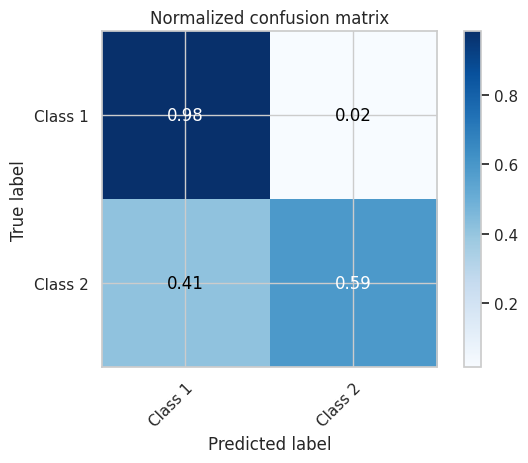

time: 468 ms (started: 2024-05-06 03:07:44 +08:00)


In [58]:
plot_confusion_matrix(rep_y_test, pred_y, classes=np.array(['Class 1', 'Class 2']), normalize=True)
plt.show()

*支持向量机测试中文数据集*

In [59]:
# Load the model
clf = load('/home/Q/Diploma_thesis/CAE_ADD-main/models/SVM_CAE_norm_1k.joblib')

# Predict on zh_test_val
pred_y = clf.predict(data_zh_encoded)

# Print classification report
print("Classification Report: SVM on latent")
print(classification_report(data_zh_label, pred_y))

# Print accuracy score
print("Accuracy Score: ", accuracy_score(data_zh_label, pred_y))

# Compute and normalize confusion matrix
cm = confusion_matrix(data_zh_label, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print diagonal elements and the whole confusion matrix
print(cm.diagonal())
print(cm)
print(confusion_matrix(data_zh_label, pred_y))

Classification Report: SVM on latent
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       749
           1       0.74      0.73      0.73       750

    accuracy                           0.73      1499
   macro avg       0.73      0.73      0.73      1499
weighted avg       0.73      0.73      0.73      1499

Accuracy Score:  0.7344896597731821
[0.74098798 0.728     ]
[[0.74098798 0.25901202]
 [0.272      0.728     ]]
[[555 194]
 [204 546]]
time: 14.7 s (started: 2024-05-06 03:07:46 +08:00)


Normalized confusion matrix
[[0.74098798 0.25901202]
 [0.272      0.728     ]]


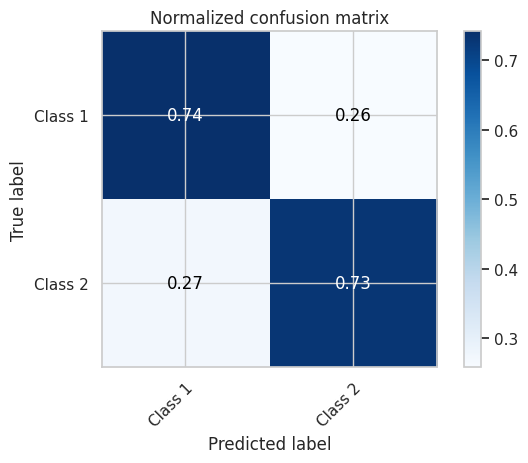

time: 274 ms (started: 2024-05-02 11:32:52 +08:00)


In [41]:
plot_confusion_matrix(data_zh_label, pred_y, classes=np.array(['Class 1', 'Class 2']), normalize=True)
plt.show()

In [42]:
# Load the model
clf = load('/home/Q/Diploma_thesis/CAE_ADD-main/models/SVM_CAE_norm_1k.joblib')

# Predict on zh_test_val
pred_y = clf.predict(data_zh_2_encoded)

# Print classification report
print("Classification Report: SVM on latent")
print(classification_report(data_zh_2_label, pred_y))

# Print accuracy score
print("Accuracy Score: ", accuracy_score(data_zh_2_label, pred_y))

# Compute and normalize confusion matrix
cm = confusion_matrix(data_zh_2_label, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print diagonal elements and the whole confusion matrix
print(cm.diagonal())
print(cm)
print(confusion_matrix(data_zh_2_label, pred_y))

Classification Report: SVM on latent
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      3599
           1       0.54      0.41      0.46      2230

    accuracy                           0.64      5829
   macro avg       0.61      0.60      0.60      5829
weighted avg       0.63      0.64      0.63      5829

Accuracy Score:  0.639560816606622
[0.78216171 0.40941704]
[[0.78216171 0.21783829]
 [0.59058296 0.40941704]]
[[2815  784]
 [1317  913]]
time: 24.7 s (started: 2024-05-02 11:33:34 +08:00)


In [34]:
# 支持向量机-寻找最佳参数
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

# 创建GridSearchCV对象
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# 开始搜索最佳参数
grid.fit(rep_x_Train, rep_y_Train)

# 打印最佳参数,grid.best_score_是最佳参数的得分
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# 使用最佳参数进行预测
grid_predictions = grid.predict(rep_x_Valid)

# 打印分类报告和准确度
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, grid_predictions))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, grid_predictions))

cm = confusion_matrix(rep_y_Valid, grid_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())

tf.keras.backend.clear_session()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.521 total time=  28.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.499 total time=  29.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.502 total time=  28.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=  29.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.503 total time=  28.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.711 total time=  24.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.624 total time=  21.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.708 total time=  23.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.656 total time=  19.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.645 total time=  22.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.683 total time=  24.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [29]:
# 使用随机森林模型-训练
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=None)
rf_clf.fit(rep_x_Train, rep_y_Train)
rf_pred_y = rf_clf.predict(rep_x_Valid)

# Save the model
dump(clf, '/home/Q/Diploma_thesis/CAE_ADD-main/models/RF_CAE_norm_1k.joblib') 

print("Random Forest Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, rf_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, rf_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, rf_pred_y))

Random Forest Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.68      1149
         1.0       0.68      0.77      0.72      1149

    accuracy                           0.70      2298
   macro avg       0.71      0.70      0.70      2298
weighted avg       0.71      0.70      0.70      2298

Accuracy Score: 0.7049608355091384
Confusion Matrix:
[[734 415]
 [263 886]]
time: 53.1 s (started: 2024-05-02 10:32:05 +08:00)


Normalized confusion matrix
[[0.63881636 0.36118364]
 [0.22889469 0.77110531]]


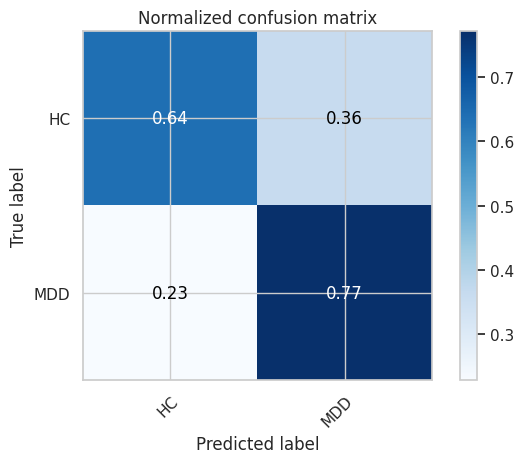

time: 242 ms (started: 2024-05-02 10:33:32 +08:00)


In [30]:
plot_confusion_matrix(rep_y_Valid, rf_pred_y, classes=np.array(['HC', 'MDD']), normalize=True)
plt.show()

In [32]:
# 使用随机森林模型-测试-en
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import load

# Load the model
clf = load('/home/Q/Diploma_thesis/CAE_ADD-main/models/RF_CAE_norm_1k.joblib')

# Predict on zh_test_val
rf_pred_y = clf.predict(rep_x_test)

# Print classification report
print("Classification Report: RF on latent")
print(classification_report(rep_y_test, rf_pred_y))

# Print accuracy score
print("Accuracy Score: ", accuracy_score(rep_y_test, rf_pred_y))

# Compute and normalize confusion matrix
cm = confusion_matrix(rep_y_test, rf_pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print diagonal elements and the whole confusion matrix
print(cm.diagonal())
print(cm)
print(confusion_matrix(rep_y_test, rf_pred_y))


Classification Report: RF on latent
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.80      1527
         1.0       0.99      0.52      0.68      1527

    accuracy                           0.76      3054
   macro avg       0.83      0.76      0.74      3054
weighted avg       0.83      0.76      0.74      3054

Accuracy Score:  0.7583497053045186
[0.99607073 0.52062868]
[[0.99607073 0.00392927]
 [0.47937132 0.52062868]]
[[1521    6]
 [ 732  795]]
time: 12.7 s (started: 2024-05-02 10:33:57 +08:00)


In [33]:
# 使用随机森林模型-测试-zh
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import load

# Load the model
rf_clf = load('/home/Q/Diploma_thesis/CAE_ADD-main/models/RF_CAE_norm_1k.joblib')

# Predict on zh_test_val
rf_pred_y = rf_clf.predict(rep_x_sampled)

# Print classification report
print("Classification Report: RF on latent")
print(classification_report(rep_y_sampled, rf_pred_y))

# Print accuracy score
print("Accuracy Score: ", accuracy_score(rep_y_sampled, rf_pred_y))

# Compute and normalize confusion matrix
cm = confusion_matrix(rep_y_sampled, rf_pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print diagonal elements and the whole confusion matrix
print(cm.diagonal())
print(cm)
print(confusion_matrix(rep_y_sampled, rf_pred_y))

Classification Report: RF on latent
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76      1462
         1.0       0.99      0.41      0.58      1538

    accuracy                           0.69      3000
   macro avg       0.80      0.70      0.67      3000
weighted avg       0.81      0.69      0.67      3000

Accuracy Score:  0.6946666666666667
[0.99384405 0.41027308]
[[0.99384405 0.00615595]
 [0.58972692 0.41027308]]
[[1453    9]
 [ 907  631]]
time: 14.8 s (started: 2024-05-02 10:35:06 +08:00)


In [36]:
# 随机森林-寻找最佳参数
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {'n_estimators': [50, 100, 200, 500, 1000], 
              'max_depth': [None, 10, 20, 30, 40, 50]} 

# 创建GridSearchCV对象
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)

# 开始搜索最佳参数
grid.fit(rep_x_Train, rep_y_Train)

# 打印最佳参数
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# 使用最佳参数进行预测
grid_predictions = grid.predict(rep_x_Valid)

# 打印分类报告和准确度
print ("Classification Report:")
print (classification_report(rep_y_Valid, grid_predictions))
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, grid_predictions))
print ("Confusion Matrix:")
print (confusion_matrix(rep_y_Valid, grid_predictions))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

time: 18.2 s (started: 2024-05-02 11:29:30 +08:00)


In [13]:
# 使用决策树模型
dt_clf = DecisionTreeClassifier()
dt_clf.fit(rep_x_Train, rep_y_Train)
dt_pred_y = dt_clf.predict(rep_x_Valid)

print("\nDecision Tree Classifier:")
print("Classification Report:")
print(classification_report(rep_y_Valid, dt_pred_y))
print("Accuracy Score:", accuracy_score(rep_y_Valid, dt_pred_y))
print("Confusion Matrix:")
print(confusion_matrix(rep_y_Valid, dt_pred_y))


Decision Tree Classifier:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57      1149
         1.0       0.60      0.75      0.67      1149

    accuracy                           0.62      2298
   macro avg       0.63      0.62      0.62      2298
weighted avg       0.63      0.62      0.62      2298

Accuracy Score: 0.6240208877284595
Confusion Matrix:
[[572 577]
 [287 862]]
